# JaxRK quick start

JaxRK is a library for working with (vectors of) RKHS elements and RKHS operators using [JAX](https://github.com/google/jax) for automatic differentiation. This library includes implementations of [kernel transfer operators](https://arxiv.org/abs/1712.01572) and [conditional density operators](https://arxiv.org/abs/1905.11255).

First off, lets see how we create RKHS elements. Import necessary packages, first.

In [3]:
import jax.numpy as np, pylab as pl
from jaxrk.rkhs import Cdo, Cmo, LinOp, FiniteVec, inner, CovOp, Cov_solve, Cov_inv
from jaxrk.kern import GenGaussKernel, SplitDimsKernel, PeriodicKernel
from jaxrk.reduce import *
from jax import random


key1, key2 = random.split(random.PRNGKey(0))

/Users/ingmar/Devel/python/jax/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


Init Plugin
Init Graph Optimizer
Init Kernel


RKHS elements are special cases of RKHS vectors. As an example, we create $e_1 = \sum_{j=0}^5 k(j, \cdot)$ and $e_1 = \sum_{j=0}^5  \frac{1}{6} k(j, \cdot)$, where $k$ is a Laplace kernel.

In [4]:
k = GenGaussKernel.make_laplace(
    1.0,
)

# input space points are expected to be have shape of length 2
input_space_points = np.arange(6)[:, np.newaxis]

ones = np.ones(6)
p_ones = Prefactors(ones)
one_sixth = ones / 6
p_one_sixth = Prefactors(one_sixth)
e1 = FiniteVec.construct_RKHS_Elem(k, input_space_points, ones)
e2 = FiniteVec.construct_RKHS_Elem(k, input_space_points, one_sixth)
v1 = FiniteVec(k, input_space_points, [p_ones])
v2 = FiniteVec(k, input_space_points, [p_one_sixth])
w1 = FiniteVec(k, input_space_points, [p_one_sixth, BalancedRed(3)])
w2 = FiniteVec(k, input_space_points, [Prefactors(np.arange(1, 7)), BalancedRed(2)])

In particular, RKHS elements are RKHS vectors of length one.

In [5]:
print(len(e1), len(e2))

1 1


Next, lets see how we create vectors of RKHS elements (sometimes called feature matrices or feature vectors).
To keep it simple, lets reuse the input space points and real prefactors from before to create $v_1 = [k(0, \cdot), \dots, k(5, \cdot)]$ and $v_2 = [\frac{1}{6}k(0, \cdot), \dots, \frac{1}{6}k(5, \cdot)]$.

In [6]:
print(len(v1), len(v2))

6 6


RKHS elements can be more complex: summing scaled RKHS elements results in an RKHS element. Now lets create two vectors, one containing two RKHS elements $w_1=[\sum_{j=0}^{2} \frac{1}{6} k(j, \cdot), \sum_{j=3}^{5} \frac{1}{6}  k(j, \cdot)]$ the other containing three RKHS elements $w_2=[\sum_{j=0}^{1} (j+1) k(j, \cdot), \sum_{j=2}^{3} (j+1) k(j, \cdot), \sum_{j=4}^{5} (j+1)  k(j, \cdot)]$.
How many summands go into each RKHS element is determined by the `points_per_split` argument.

In [7]:
print(len(input_space_points), len(w1), len(w2))

6 2 3


Now we can compute the RKHS inner products of all pairs $(a, b)$ where $a$ comes from one RKHS vector and $b$ comes from the other. For example `inner(v1, v1)` is the plain old gram matrix of input space points of v1. More complex computation is automatically attended to, for example `inner(v1, w1)` is of size $6 \times 2$, as expected.

In [8]:
v1_w1, v1_e1 = inner(v1, w1), inner(v1, e1)
print("inner(v1, w1) is of shape", v1_w1.shape, "and equals\n", v1_w1, "\n\n")
print("inner(v1, e1) is of shape", v1_e1.shape, "and equals\n", v1_e1, "\n\n")

inner(v1, w1) is of shape (6, 2) and equals
 [[0.12526783 0.00623672]
 [0.14464651 0.01695316]
 [0.12526783 0.04608346]
 [0.04608346 0.12526783]
 [0.01695316 0.14464651]
 [0.00623672 0.12526783]] 


inner(v1, e1) is of shape (6, 1) and equals
 [[0.78902733]
 [0.969598  ]
 [1.0281078 ]
 [1.0281078 ]
 [0.969598  ]
 [0.78902733]] 




### Conditonal density estimates using the CDO

In what follows, we will create a simple data set and do conditional density estimates for it using the  [conditional density operator (CDO)](https://arxiv.org/abs/1905.11255).

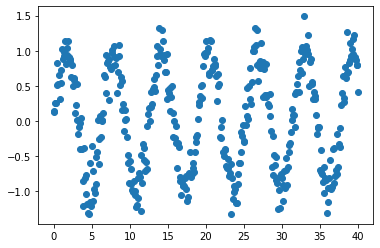

In [9]:
from numpy.random import randn
from jax import random

x = np.linspace(0, 40, 400).reshape((-1, 1))
rng_key = random.PRNGKey(0)
y = np.sin(x) + random.normal(rng_key, (len(x), 1)) * 0.2

pl.scatter(x.T, y.T)

In [10]:
def plot_pred(mean_var, x, y, points_per_split=1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)

    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[: 200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split :].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(
        x[200:].flatten(),
        mean_var.T[0].flatten() + sd,
        mean_var.T[0].flatten() - sd,
        color="red",
        alpha=0.2,
    )

Now, lets build a simple model regressing from index to output distribution using the prior information that the output depends periodically on the input. This is encoded in the fact that the input features use a periodic kernel.

In [11]:
out_kern = GenGaussKernel.make_gauss(
    0.4,
)
refervec = FiniteVec(
    out_kern, np.linspace(y[:-201].min() - 2, y[:-201].max() + 2, 6000)[:, None], []
)
invec = FiniteVec(PeriodicKernel(2 * np.pi, 1.0), x[:200])
outvec = FiniteVec(out_kern, y[:200])
cov = CovOp(outvec)

Now the conditional density operator `cd` uses these input and output features along with a feature vector encoding the uniform reference measure, `refervec`.
We apply it to all input locations that we are interested in, `x[199:399]`, by calling the `apply` function with a feature vector for the input locations. This returns a vector of RKHS objects which approximate the conditional probabilities. We normalize these and compute the closed form mean and variance of these conditional probabilities.

In [12]:
from jaxrk.rkhs import Cov_inv

cov_i = Cov_inv(cov, regul=0.7672705)
s = cov_i @ outvec.mean()
# s2 = outvec.updated(s.reduce[-2].linear_map.squeeze()/s.reduce[-2].linear_map.sum()).extend_reduce([Sum()])
G = outvec.k(outvec.insp_pts)
G_i = np.linalg.inv(G + 0.7672705 * np.eye(200))
G_i2 = G_i @ G_i
s3 = Cov_solve(cov, outvec.mean())

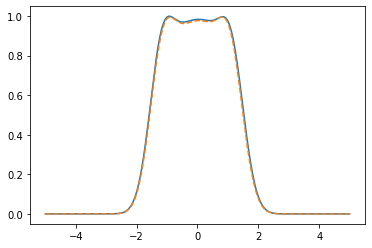

In [13]:
#%debug
test_x = np.linspace(-5, 5, 3000)
pl.plot(test_x, s(test_x[:, None]).squeeze())
# pl.plot(test_x, s2(test_x[:,None]).squeeze())
pl.plot(test_x, s3(test_x[:, None]).squeeze(), "--")

In [14]:
out_kern = GenGaussKernel.make_gauss(
    0.4,
)
refervec = FiniteVec(
    out_kern, np.linspace(y[:200].min() - 2, y[:200].max() + 2, 6000)[:, None], []
)
# invec = FiniteVec(GenGaussKernel.make_laplace(0.1,), x[:200])
invec = FiniteVec(PeriodicKernel(2 * np.pi, 12), x[:200])
outvec = FiniteVec(out_kern, y[:200])

op = {
    "CDO": Cdo(invec, outvec, refervec, regul=None),
    "CMO": Cmo(invec, outvec, regul=None),
}

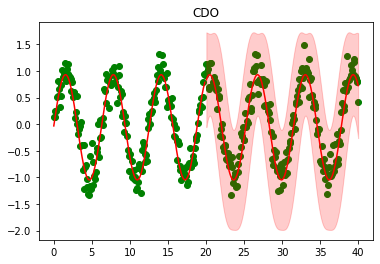

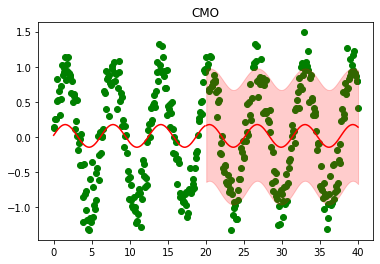

<Figure size 432x288 with 0 Axes>

In [15]:
for l in op:
    mv = np.array((op[l] @ FiniteVec(invec.k, x)).get_mean_var()).T
    plot_pred(mv[199:399, :], x, y)
    pl.plot(x[:199], mv[:199, 0], "r")
    pl.title(l)
    pl.figure()

Now lets say we have 10 observations per input location. This is easily reflected by using more complex RKHS elements as output feature vectors.

In [16]:
y2 = (np.sin(x) + randn(len(x) * 10).reshape((-1, 10)) * 0.2).reshape((-1, 1))
outvec2 = FiniteVec(out_kern, y2[:2000], [BalancedRed(10, average=True)])

Lets compute conditional density estimates again.

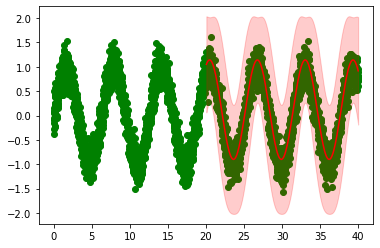

In [17]:
cd = Cdo(invec, outvec2, refervec)
mean_var = np.array((cd @ FiniteVec(invec.k, x[199:399])).get_mean_var()).T

mean_var.shape
plot_pred(mean_var, x, y2, points_per_split=10)

The advantage of using `BalancedRed` is computational. As there are 2000 different output values in the training dataset, whe would have to compute a $2000\times2000$ gram matrix by using the standard computation. By using the fact that we only have $200$ different locations, internally the gram matrix is reduced to $200\times 200$ before inverting it for the CDO estimate. This can save huge amounts of computation!

Another model for our original data would be a simple state space model with dependencies 10 timesteps back, which is what we build next. First, again, we construct input and output feature vectors.

In [18]:
invec = FiniteVec(
    GenGaussKernel.make_gauss(0.8), np.vstack([y[i : i + 10].T for i in range(190)])
)
outvec = FiniteVec(out_kern, y[10:200])

The rest, i.e. applying `cd` to produce the predictions we're intersted in, is analogous to the previous example.

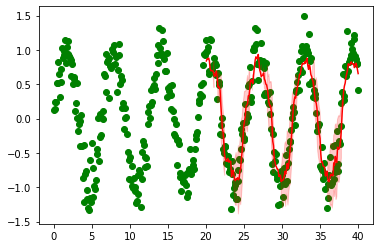

In [19]:
cd = Cdo(invec, outvec, refervec)
mean_var = np.array(
    (cd @ FiniteVec(invec.k, np.vstack([y[end - 10 : end].T for end in range(200, 400)])))
    .normalized()
    .get_mean_var()
).T
plot_pred(mean_var, x, y)

## Summary

JaxRK is a library for modern kernel methods using conditonal mean embeddings, density estimates that are RKHS elements, and manipulating RKHS elements in a transparent yet efficient way. If you have questions or improvements, please open an issue or pull request.